In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, auc
from sklearn.ensemble import RandomForestClassifier
from source import downsample_binary, my_tokenizer
import joblib


In [3]:
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
# feature union to combine 1-gram and 2-gram features
combined_features = FeatureUnion([
    ('1gram', tfidf),
    ('2gram', tfidf_2grams)
])

In [5]:
df = pd.read_pickle("../data/reviews_vector_FINAL.pkl")

In [6]:
df.duplicated(subset=df.columns[5:]).sum()

81274

In [7]:
# Splitting the main data
X=df.drop("binary",axis=1)
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
test_later = X_test

In [9]:
#downsampling X_train
balanced_set = downsample_binary(y_train, X_train)

In [10]:
X_train.columns

Index(['overall', 'reviewText', 'asin', 'length', '1gram__10', '1gram__100',
       '1gram__6s', '1gram__abl', '1gram__absolut', '1gram__access',
       ...
       '2gram__well made', '2gram__work fine', '2gram__work good',
       '2gram__work great', '2gram__work like', '2gram__work perfectli',
       '2gram__work well', '2gram__would buy', '2gram__would definit',
       '2gram__would recommend'],
      dtype='object', length=604)

In [11]:
X_train_unvec = X_train["reviewText"]
X_train = X_train[X_train.columns[4:]]
X_test_unvec = X_test["reviewText"]
X_test = X_test[X_test.columns[4:]]


In [12]:
# balanced class training sets
X_train_bal = balanced_set[balanced_set.columns[5:]]
y_train_bal = balanced_set["binary"]

X_train_bal_unvec = balanced_set["reviewText"]

In [11]:

random_forest_model = RandomForestClassifier(n_estimators=30, random_state=42) 
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=30, random_state=42)

In [12]:
tree_depths = [tree.get_depth() for tree in random_forest_model.estimators_]

max_depth = max(tree_depths)
min_depth = min(tree_depths)
avg_depth = sum(tree_depths) / len(tree_depths)

print(f"Maximum depth in any tree: {max_depth}")
print(f"Minimum depth in any tree: {min_depth}")
print(f"Average depth across all trees: {avg_depth}")

Maximum depth in any tree: 761
Minimum depth in any tree: 640
Average depth across all trees: 699.2


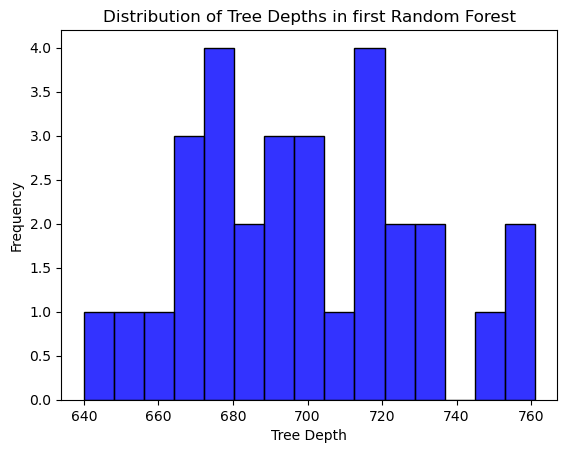

In [13]:
sns.histplot(tree_depths, alpha=0.8, color='blue', bins=15)
plt.xlabel('Tree Depth')
plt.ylabel('Frequency')
plt.title('Distribution of Tree Depths in first Random Forest')
plt.show()

As we can see, the default Random Forest creates 30 *specialized* decision trees, each given a sample of both features and reviews from the overall train set. Each tree is then maximally overfitted, such that every leaf is pure. The range in tree depths is due to the sample fed to each tree being different in size, the resulting overfitted tree has a different length to different one. When we optimise the forest, one of the hyperperameters we tune is "max_depth=k". Setting this will force all $N$ estimators to be of depth $k$. We tune this so ideally most trees are underfitted, although I will compare different "setups". 

In [15]:
y_train_predicted = random_forest_model.predict(X_train)
y_test_predicted = random_forest_model.predict(X_test)
print(classification_report(y_test, y_test_predicted))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65     33949
           1       0.88      0.94      0.91    108208

    accuracy                           0.85    142157
   macro avg       0.82      0.76      0.78    142157
weighted avg       0.85      0.85      0.85    142157



In [ ]:
estimators = [
              ('model', RandomForestClassifier(n_estimators=30, random_state=42))]
pipe = Pipeline(estimators)

params = {
    'model__criterion': ["entropy"],
    'model__n_estimators': [60,80],
    'model__random_state':[42],
    'model__max_depth': [300,500,600]
    # 'model__min_samples_leaf': [3,5]
    # # 'model__min_samples_split':[5,10]  
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2, cv=3)
fitted_forest = grid_search.fit(X_train, y_train)

In [14]:

estimators_f = [('vectorize', combined_features),
              ('model', RandomForestClassifier(n_estimators=60, max_depth=300,random_state=42))]
pipe_final = Pipeline(estimators_f)
pipe_final.fit(X_train_unvec, y_train)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x1528968b0>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x1528968b0>))])),
                ('model',
                 RandomForestClassifier(max_depth=300, n_estimators=60,
                                        random_state=42))])

In [21]:
tree_depths = [tree.get_depth() for tree in pipe_final[-1].estimators_]

max_depth = max(tree_depths)
min_depth = min(tree_depths)
avg_depth = sum(tree_depths) / len(tree_depths)

print(f"Maximum depth in any tree: {max_depth}")
print(f"Minimum depth in any tree: {min_depth}")
print(f"Average depth across all trees: {avg_depth}")

Maximum depth in any tree: 300
Minimum depth in any tree: 300
Average depth across all trees: 300.0


In [ ]:
estimators_bal = [
              ('model', RandomForestClassifier(n_estimators=30, random_state=42))]
pipe_bal = Pipeline(estimators_bal)

params_bal = {
    'model__criterion': ["entropy"],
    'model__n_estimators': [60,80],
    'model__random_state':[42],
    'model__max_depth': [300,500,600]
    # 'model__min_samples_leaf': [3,5]
    # # 'model__min_samples_split':[5,10]  
}

grid_search_bal = GridSearchCV(pipe_bal, param_grid=params_bal, verbose=3, n_jobs=2, cv=3)
fitted_forest_bal = grid_search_bal.fit(X_train_bal, y_train_bal)

In [ ]:
fitted_forest_bal.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 RandomForestClassifier(criterion='entropy', max_depth=600,
                                        n_estimators=80, random_state=42))])

In [15]:

estimators_f_bal = [('vectorize', combined_features),
              ('model', RandomForestClassifier(n_estimators=80, max_depth=600,random_state=42))]
pipe_final_bal = Pipeline(estimators_f_bal)
pipe_final_bal.fit(X_train_bal_unvec, y_train_bal)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x1528968b0>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x1528968b0>))])),
                ('model',
                 RandomForestClassifier(max_depth=600, n_estimators=80,
                                        random_state=42))])

In [16]:
joblib.dump(pipe_final, "../model/random-forest-unbal-model.pkl")
joblib.dump(pipe_final_bal, "../model/random-forest-bal-model.pkl")



['../model/random-forest-bal-model.pkl']

In [14]:
# pipe_final_bal=joblib.load("../model/random-forest-bal-model.pkl")
# pipe_final=joblib.load("../model/random-forest-unbal-model.pkl")

In [15]:
y_train_pred_f = pipe_final.predict(X_train_unvec)
y_test_pred_f = pipe_final.predict(X_test_unvec) 


In [16]:
y_train_pred_f_bal = pipe_final_bal.predict(X_train_unvec)
y_test_pred_f_bal = pipe_final_bal.predict(X_test_unvec) 


In [1]:
cm = confusion_matrix(y_test, y_test_pred_f)
cm_norm = confusion_matrix(y_test, y_test_pred_f, normalize="true")


NameError: name 'confusion_matrix' is not defined

In [18]:
cm_bal = confusion_matrix(y_test, y_test_pred_f_bal)
cm_bal_norm = confusion_matrix(y_test, y_test_pred_f_bal, normalize="true")


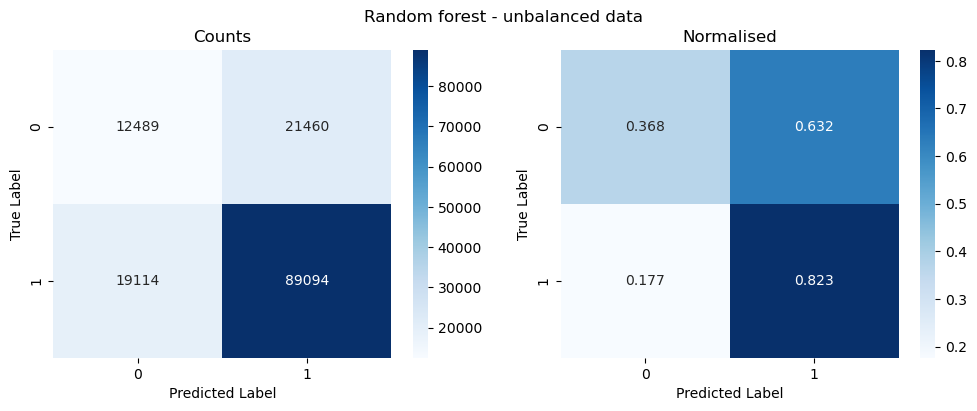

In [19]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Random forest - unbalanced data")
plt.show()


NameError: name 'cm_bal' is not defined

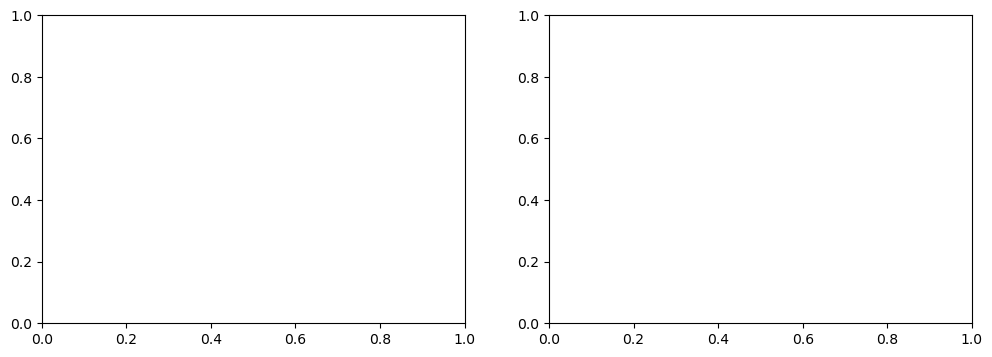

In [12]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_bal_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.title("Normalised")
plt.show()


In [40]:
print(classification_report(y_test, y_test_pred_f))

              precision    recall  f1-score   support

           0       0.40      0.37      0.38     33949
           1       0.81      0.82      0.81    108208

    accuracy                           0.71    142157
   macro avg       0.60      0.60      0.60    142157
weighted avg       0.71      0.71      0.71    142157



In [41]:
print(classification_report(y_test, y_test_pred_f_bal))

              precision    recall  f1-score   support

           0       0.57      0.83      0.68     33949
           1       0.94      0.80      0.87    108208

    accuracy                           0.81    142157
   macro avg       0.75      0.82      0.77    142157
weighted avg       0.85      0.81      0.82    142157



In [46]:
# for ROC later
y_proba_test = pipe_final.predict_proba(X_test_unvec)
y_proba_test_bal = pipe_final_bal.predict_proba(X_test_unvec)

In [47]:
fpr_unbal, tpr_unbal, thresholds_unbal = roc_curve(y_test.values,y_proba_test[:,1])
roc_auc1 = auc(fpr_unbal, tpr_unbal)


In [48]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test.values,y_proba_test_bal[:,1])
roc_auc2 = auc(fpr_bal, tpr_bal)


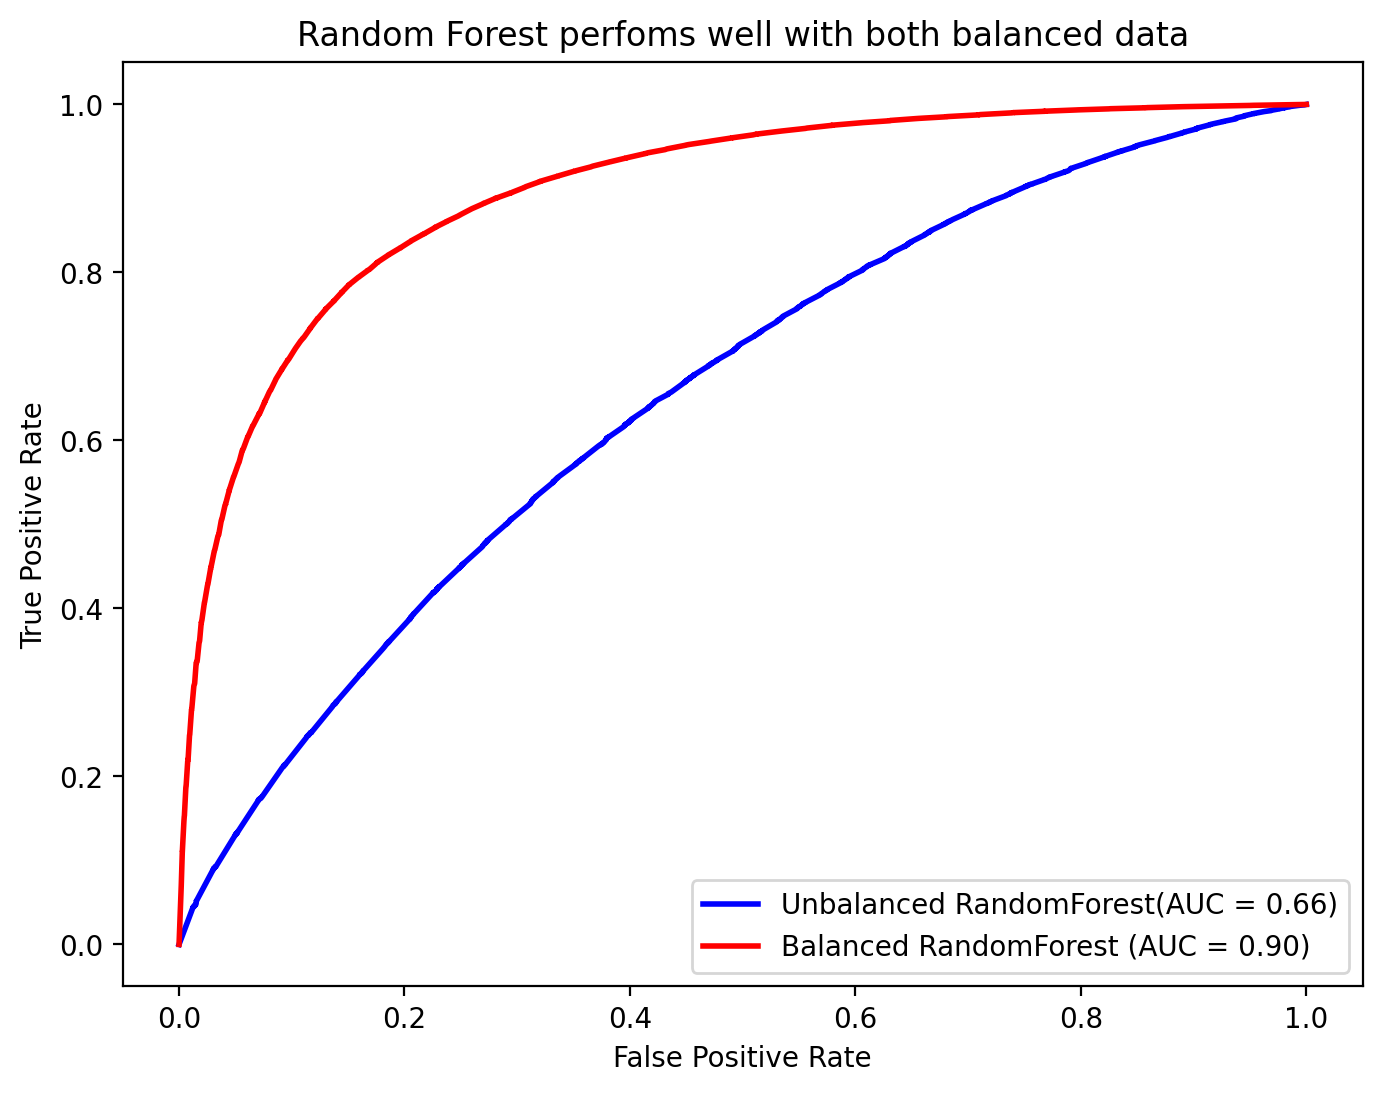

In [50]:
%config InlineBackend.figure_format="retina"
plt.figure(figsize=(8, 6))

# ROC curve for unbalanced model
plt.plot(fpr_unbal, tpr_unbal, color='blue', lw=2, label='Unbalanced RandomForest(AUC = %0.2f)' % roc_auc1)

# ROC curve for balanced model
plt.plot(fpr_bal, tpr_bal, color='red', lw=2, label='Balanced RandomForest (AUC = %0.2f)' % roc_auc2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest perfoms well with both balanced data')
plt.legend()


plt.show()

In [77]:
with open('ranfor_roc_data.pkl', 'wb') as f:
    joblib.dump({'fpr_unbal': fpr_unbal, 'tpr_unbal': tpr_unbal, 'roc_auc1': roc_auc1,
                 'fpr_bal': fpr_bal, 'tpr_bal': tpr_bal, 'roc_auc2': roc_auc2}, f)

In [71]:

incorrect_guesses = y_test != y_test_pred_f

incorrect_v = pd.Series(y_test)[incorrect_guesses]
# ig = pd.concat([pd.Series(y_test_pred_f[incorrect_guesses]),pd.Series(incorrect_v), test_later[incorrect_guesses]], axis=1, ignore_index=True)
# ig.rename(columns={0:"guess"}, inplace=True)

In [75]:
y_test_pred_f[incorrect_v]

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
rev = ig.loc[223051]
text = rev["reviewText"]
print(f"Actual: {rev['binary']}, Guess: {rev[0]}, Overall: {int(rev['overall'])}")
print(f"Review: {text[:45]} \n{text[45: 100]} \n{text[101:152]} \n{text[153:]}")

In [54]:
feature_values = ig.loc[2, df.columns[5:]].values.reshape(1, -1)
fi = random_forest_model.feature_importances_
fi.reshape(1,-1).shape

feature_contributions = pd.DataFrame(fi.reshape(1,-1), columns=X.columns, index=['Contribution']).T
sorted_contributions = feature_contributions.sort_values(by='Contribution', ascending=False)

print(sorted_contributions.head(10))

NameError: name 'ig' is not defined